## Uber demand forecasting for New York City
This is a short example to demonstrate the different and subsequent steps of a machine learning project.<br>
The goal of the project is to predict the demand of uber services in advance. 

### Setup

Import necessary libraries.

In [1]:
import os
import numpy as np
import pandas as pd

import json
# from area import area
from matplotlib import path

%matplotlib inline
from matplotlib import pyplot as plt

Set the number of CPUs to be used.

In [2]:
# value 1 -> use 1 CPU
# value 2 -> use 2 CPUs ...
# value -1 -> use all CPUs
# value -2 -> use all but one CPU ...
n_cpus = -2

### Get the data
Get the data for the Uber pickups for NYC for the time period April to September 2014 from the following sources:
```txt
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-may14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jun14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-jul14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-aug14.csv
https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-sep14.csv

```

In [3]:
import urllib

# source from where to download the data
SOURCE_ROOT = 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/'

# dictionary of the files to be downloaded
month_url = {'april_data' :'uber-raw-data-apr14.csv', 'may_data' :'uber-raw-data-may14.csv',
            'june_data' :'uber-raw-data-jun14.csv', 'july_data' :'uber-raw-data-jul14.csv',
            'august_data' :'uber-raw-data-aug14.csv', 'september_data' :'uber-raw-data-sep14.csv'}

# path to store the downloaded data
SAVING_PATH = os.path.join('datasets')

# function to fetch the data
def download_and_save_data(data_source_url = SOURCE_ROOT, data_path = SAVING_PATH):
    # make data directory if not existing
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
        # get data csv for each month
        for month in month_url:
            data_url = ''
            file_name = month_url[month]

            # status print
            print('download and save {}'.format(file_name))

            # setup the data url
            data_url = data_source_url + file_name

            # specify the douwnload file
            csv_path = os.path.join(data_path, file_name)

            # receive the data from the web
            urllib.request.urlretrieve(data_url, csv_path)

# call the function to download and save the data
download_and_save_data()

Convert the `CSV` files into a pandas `DataFrame` files and store them in a dictionary.

In [4]:
def load_csv_data(csv_path):
    return pd.read_csv(csv_path)

In [5]:
data_dict = {}

for month in month_url:
    csv_filename = month_url[month]
    csv_path = os.path.join(SAVING_PATH, csv_filename)
    pd_filename = month
    data_dict.update({pd_filename : load_csv_data(csv_path)})

In [6]:
data_dict.keys()

dict_keys(['april_data', 'may_data', 'june_data', 'july_data', 'august_data', 'september_data'])

## Analise the raw data

In [7]:
x = data_dict['april_data']

Print the first ten data rows.

In [8]:
x.head(10)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
5,4/1/2014 0:33:00,40.7383,-74.0403,B02512
6,4/1/2014 0:39:00,40.7223,-73.9887,B02512
7,4/1/2014 0:45:00,40.7620,-73.9790,B02512
8,4/1/2014 0:55:00,40.7524,-73.9960,B02512
9,4/1/2014 1:01:00,40.7575,-73.9846,B02512


The data consists of four columns with five parameters:

`Data`: The date of the Uber pickup.
<br>
`Time`: The time of the Uber pickup.
<br>
`Lat`: The latitude of the Uber pickup.
<br>
`Lon`: The longitude of the Uber pickup.
<br>
`Base`: The TLC base company code affiliated with the Uber pickup.

Check the amount and completeness of the data point.

In [9]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564516 entries, 0 to 564515
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date/Time  564516 non-null  object 
 1   Lat        564516 non-null  float64
 2   Lon        564516 non-null  float64
 3   Base       564516 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.2+ MB


There are 564516 entries with no missing data point.

`Lon` ans `Lat` are of *float64* data type. These values can be used after scaling them (see later) without further preprocessing. 

`Date/Time` is of type *object* and therefore needs to be converted into a time series format.

`Base` is also of type *object*. We will use one-hot-encoding here.

Lets have a closer look at the `Base` parameter.

In [10]:
x['Base'].value_counts()

B02682    227808
B02598    183263
B02617    108001
B02512     35536
B02764      9908
Name: Base, dtype: int64

The `Base` parameter has five different values.

## Preprocess the data

### Add the label parameter
Add a new parameter `pickups` to count the number of pickups. **This will be the label!**

In [11]:
x['Pickups'] = 1

In [12]:
x.head()

,Date/Time,Lat,Lon,Base,Pickups
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,1
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1


### Add new parameter `Neighborhood` to cluster the longitude and latitude into spatial clusters 
Add an additional column for a new parameter called *neighborhood*. This column stores the neighborhoods of NYC generated out of the latitude and longitude values.

In [13]:
x_add = x.copy()

In [14]:
x_add['Neighborhood'] = np.zeros(len(x_add))

In [15]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1,0.0
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,1,0.0
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1,0.0
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1,0.0
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1,0.0
...,...,...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764,1,0.0
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764,1,0.0
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764,1,0.0
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764,1,0.0


Load a JSON file with the *latitude / longitude* to *neighborhood* correlation.

In [16]:
# geofile = json.load(open("datasets/Neighborhood_Tabulation_Areas.geojson"))
# geofile = json.load(open("datasets/NY_neighborhoods.geojson"))
geofile = json.load(open("NY_neighborhoods.geojson"))

In [17]:
geo_points = list(zip(x_add['Lon'], x_add['Lat']))

In [18]:
for feature in geofile['features']:
    coords = feature['geometry']['coordinates'][0]
    p = path.Path(coords)
    inds = p.contains_points(geo_points)
    list_neighborhoods = [str(feature['properties']['neighborhood'])]*np.sum(inds)
    x_add.loc[x_add.index[inds], 'Neighborhood'] = list_neighborhoods

In [19]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1,Upper East Side
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512,1,0
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1,East Village
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1,Midtown
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1,Midtown
...,...,...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764,1,Midtown
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764,1,Upper East Side
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764,1,Midtown
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764,1,Crown Heights


Remove all non-matching entries. These were entries with pickups outside of central NYC.

In [20]:
x_add = x_add[x_add['Neighborhood'] != 0]

In [21]:
x_add

,Date/Time,Lat,Lon,Base,Pickups,Neighborhood
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512,1,Upper East Side
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512,1,East Village
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512,1,Midtown
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512,1,Midtown
6,4/1/2014 0:39:00,40.7223,-73.9887,B02512,1,Lower East Side
...,...,...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764,1,Midtown
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764,1,Upper East Side
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764,1,Midtown
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764,1,Crown Heights


In [22]:
x_add['Neighborhood'].value_counts()

Midtown                       91453
Upper East Side               47900
Chelsea                       46122
West Village                  29000
SoHo                          26174
                              ...  
Todt Hill                         1
Stapleton                         1
New Dorp                          1
Bay Terrace, Staten Island        1
Silver Lake                       1
Name: Neighborhood, Length: 234, dtype: int64

There are 234 listed neighborhood. One should check if these neighborhood are correct. But I will not do it for now.

### Convert `Date/Time` into a time series format
Extract the `Date/Time` parameter column to convert it into a **time series format**.

In [23]:
x_timeseries = x_add.copy()

In [24]:
x_timeseries.index = pd.to_datetime(x_timeseries['Date/Time'])
x_timeseries.sort_index(inplace=True)
x_timeseries.drop(labels=['Date/Time'], axis=1, inplace=True)

In [25]:
x_timeseries

,Lat,Lon,Base,Pickups,Neighborhood
Date/Time,,,,,
2014-04-01 00:00:00,40.7215,-73.9952,B02682,1,Nolita
2014-04-01 00:00:00,40.7188,-73.9863,B02598,1,Lower East Side
2014-04-01 00:00:00,40.7637,-73.9600,B02598,1,Upper East Side
2014-04-01 00:01:00,40.7355,-73.9966,B02617,1,Greenwich Village
2014-04-01 00:02:00,40.7444,-73.9964,B02598,1,Chelsea
...,...,...,...,...,...
2014-04-30 23:59:00,40.7302,-74.0008,B02682,1,Greenwich Village
2014-04-30 23:59:00,40.6900,-73.9633,B02617,1,Clinton Hill
2014-04-30 23:59:00,40.7740,-73.8727,B02682,1,LaGuardia Airport


### Delete unnecessary parameters
Now that we have the new neighborhood parameter, we do not need `Lat` and `Lon` any more. These two parameter columns will be deleted. 

As we do not pay further attention to the `Base` parameter, this column will also be deleted but in other scenarios the `Base` can be very important.

In [26]:
x_neighbor = x_timeseries.drop(['Lat', 'Lon', 'Base'], axis = 1)
x_neighbor

,Pickups,Neighborhood
Date/Time,,
2014-04-01 00:00:00,1,Nolita
2014-04-01 00:00:00,1,Lower East Side
2014-04-01 00:00:00,1,Upper East Side
2014-04-01 00:01:00,1,Greenwich Village
2014-04-01 00:02:00,1,Chelsea
...,...,...
2014-04-30 23:59:00,1,Greenwich Village
2014-04-30 23:59:00,1,Clinton Hill
2014-04-30 23:59:00,1,LaGuardia Airport


### Cluster the data into one hour intervals
Cluster the data within time intervals of one hour.

In [27]:
x_cluster = x_neighbor.resample('H').agg({'Pickups' : 'sum', 'Neighborhood': 'nunique'})

In [28]:
x_cluster.head()

,Pickups,Neighborhood
Date/Time,,
2014-04-01 00:00:00,132,38
2014-04-01 01:00:00,66,26
2014-04-01 02:00:00,51,22
2014-04-01 03:00:00,87,41
2014-04-01 04:00:00,157,47


### Extend the data by weekdays, weekend check and hours of the day

In [29]:
x_cluster['Weekday'] = x_cluster.index.weekday
x_cluster['Is_weekend'] = x_cluster.index.map(lambda x: 1 if x.weekday() > 4 else 0)
x_cluster['Hour_of_day'] = x_cluster.index.hour
x_cluster

,Pickups,Neighborhood,Weekday,Is_weekend,Hour_of_day
Date/Time,,,,,
2014-04-01 00:00:00,132,38,1,0,0
2014-04-01 01:00:00,66,26,1,0,1
2014-04-01 02:00:00,51,22,1,0,2
2014-04-01 03:00:00,87,41,1,0,3
2014-04-01 04:00:00,157,47,1,0,4
...,...,...,...,...,...
2014-04-30 19:00:00,2814,78,2,0,19
2014-04-30 20:00:00,2729,75,2,0,20
2014-04-30 21:00:00,2268,78,2,0,21


**Conclusion**: Now we can see, that on April the 1st 2014 between midnight and 1 am where 132 pickups distributed between 38 neighborhoods. It is a Thursday, thus not a weekend and its the first hour of the day.

### Safe the data
Safe the current DataFrame.

In [30]:
x_cluster.to_csv('datasets/april_data_preprocessed.csv', index=False)

## Analise and visualize the preprocessed data
### Distribution plots

Plot the `Pickups` distribution for April 2014.

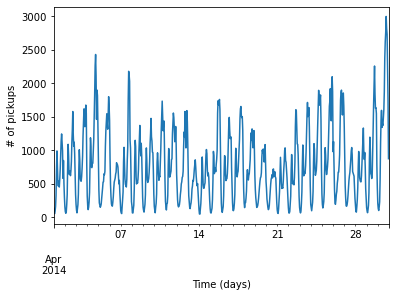

In [31]:
ax = x_cluster['Pickups'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (days)');

Plot the `Neighborhood` distribution for April 2014.

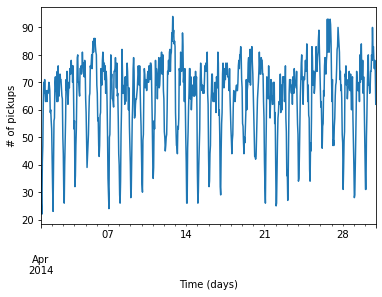

In [32]:
ax = x_cluster['Neighborhood'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (days)');

Plot the `Pickups` distribution for April the 1st 2014.

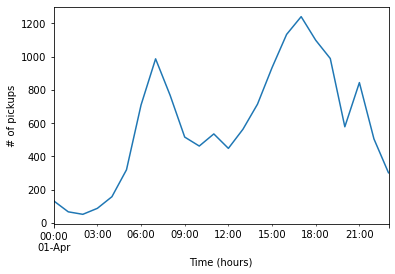

In [33]:
ax = x_cluster.loc['2014-04-01', 'Pickups'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (hours)');

Plot the `Neighborhood` distribution for April the 1st 2014.

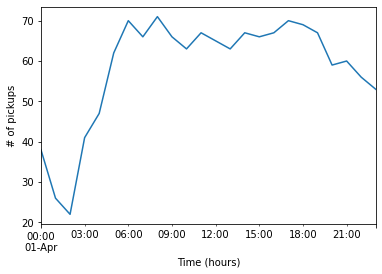

In [34]:
ax = x_cluster.loc['2014-04-01', 'Neighborhood'].plot()
ax.set_ylabel('# of pickups')
ax.set_xlabel('Time (hours)');

### Data analysis
Analise the preprocessed data.

In [35]:
x_cluster.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2014-04-01 00:00:00 to 2014-04-30 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Pickups       720 non-null    int64
 1   Neighborhood  720 non-null    int64
 2   Weekday       720 non-null    int64
 3   Is_weekend    720 non-null    int64
 4   Hour_of_day   720 non-null    int64
dtypes: int64(5)
memory usage: 53.8 KB


In [36]:
x_cluster['Pickups'].describe()

count     720.000000
mean      765.626389
std       531.286476
min        44.000000
25%       341.000000
50%       663.500000
75%      1052.750000
max      2995.000000
Name: Pickups, dtype: float64

### Correlations
Compute the ***standard correlation coefficient*** between the different **numerical attributes**.

In [37]:
corr_matrix = x_cluster.corr()
corr_matrix

,Pickups,Neighborhood,Weekday,Is_weekend,Hour_of_day
Pickups,1.000000,0.716516,-2.796910e-02,-1.328029e-01,6.201106e-01
Neighborhood,0.716516,1.000000,1.955689e-01,1.574099e-01,6.027222e-01
Weekday,-0.027969,0.195569,1.000000e+00,7.949361e-01,-1.807089e-19
Is_weekend,-0.132803,0.157410,7.949361e-01,1.000000e+00,4.150750e-17
Hour_of_day,0.620111,0.602722,-1.807089e-19,4.150750e-17,1.000000e+00


There is a high correlation between the number of pickups and the number of neighborhoods of 0.72.

##### Plot the correlations
Plot the correlations between the attributes: `Pickups` and `Neighborhood`. Use [`pandas.plotting.scatter_matrix`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) for plotting the correlations.

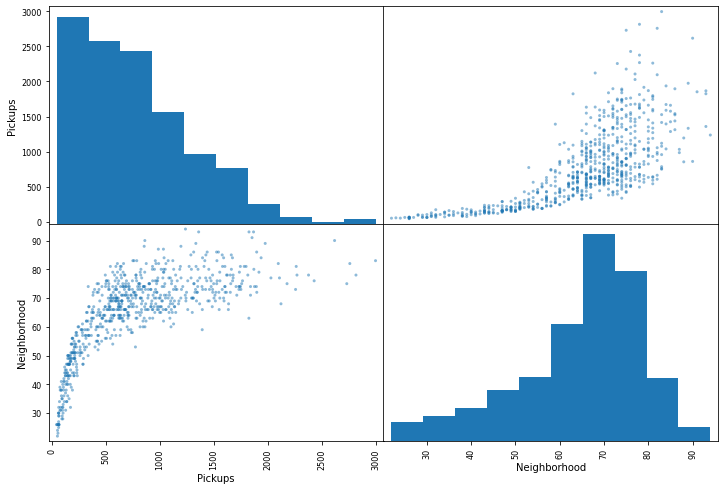

In [38]:
from pandas.plotting import scatter_matrix

attributes = ['Pickups', 'Neighborhood']
scatter_matrix(x_cluster[attributes], figsize=(12,8))
plt.show()

There is a clear *polynomial correlation* between the # of neighborhoods and the # of pickups. 

### Conclusion 
1. There is a clear correlation between time of day and number of pickups.
2. There is also a clear correlation between time of day and number of neighborhoods. 
3. There is a clear, polynomial correlation between the number of neighborhoods and the number of pickups.

### Further improvements
For better predictions the data should/could be extended by the following attributes:
1. Is it a holiday
2. Is it raining
3. Outside temperature

### Outlook 
The above mentioned correlations enable us to use machine learning models to predict the amount of pickups dependent on the time of day.

The problem we have to solve is a **regression problem**. We have to find the best approximation between the `Date/Time`, the `Neighborhood` and the `Pickups` attributes.

## Prepare the data for machine learning algorithms

### Split labels from training set
Drop the labels from the training set and move them into the "label set".

In [39]:
x_cluster.head()

,Pickups,Neighborhood,Weekday,Is_weekend,Hour_of_day
Date/Time,,,,,
2014-04-01 00:00:00,132,38,1,0,0
2014-04-01 01:00:00,66,26,1,0,1
2014-04-01 02:00:00,51,22,1,0,2
2014-04-01 03:00:00,87,41,1,0,3
2014-04-01 04:00:00,157,47,1,0,4


In [40]:
X_train = x_cluster.drop('Pickups', axis = 1)
y_train = x_cluster['Pickups'].copy()

In [41]:
X_train.head()

,Neighborhood,Weekday,Is_weekend,Hour_of_day
Date/Time,,,,
2014-04-01 00:00:00,38,1,0,0
2014-04-01 01:00:00,26,1,0,1
2014-04-01 02:00:00,22,1,0,2
2014-04-01 03:00:00,41,1,0,3
2014-04-01 04:00:00,47,1,0,4


### Missing values
Check for missing values within the attributes.

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2014-04-01 00:00:00 to 2014-04-30 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Neighborhood  720 non-null    int64
 1   Weekday       720 non-null    int64
 2   Is_weekend    720 non-null    int64
 3   Hour_of_day   720 non-null    int64
dtypes: int64(4)
memory usage: 48.1 KB


There are no missing values for the attributes.

In the case of missing values there are three possibilities to handle them:
* delete the entries with the missing values
* delete the hole attribute with the missing values
* fill the missing values with the median value of that attribute

Use `sklearn.impute.SimpleImputer` class for replacing missing values if necessary.

### Categorical attributes
Although there are no categorical attributes, the attribute `Weekday` and `Hour_of_day` have to be altered because they have growing values. Thus a machine learning algorithm may interpret larger values as more important, than smaller values. We will eliminate this by converting the numbers into categories and then using one-hot-encoder on the categorical values.

In [43]:
map_dict_weekday = {0: "Mon", 1: "Tue", 2: "Wen", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
X_train['Day_of_week'] = X_train['Weekday'].map(map_dict_weekday)
X_train.drop(labels=['Weekday'], axis=1, inplace=True)
X_train

,Neighborhood,Is_weekend,Hour_of_day,Day_of_week
Date/Time,,,,
2014-04-01 00:00:00,38,0,0,Tue
2014-04-01 01:00:00,26,0,1,Tue
2014-04-01 02:00:00,22,0,2,Tue
2014-04-01 03:00:00,41,0,3,Tue
2014-04-01 04:00:00,47,0,4,Tue
...,...,...,...,...
2014-04-30 19:00:00,78,0,19,Wen
2014-04-30 20:00:00,75,0,20,Wen
2014-04-30 21:00:00,78,0,21,Wen


In [44]:
map_dict_hour = {0: "H_1", 1: "H_2", 2: "H_3", 3: "H_4", 4: "H_5", 5: "H_6", 6: "H_7", 7: "H_8",
                8: "H_9", 9: "H_10", 10: "H_11", 11: "H_12", 12: "H_13", 13: "H_14", 14: "H_15", 15: "H_16",
                16: "H_17", 17: "H_18", 18: "H_19", 19: "H_20", 20: "H_21", 21: "H_22", 22: "H_23", 23: "H_24"}
                
X_train['Hours'] = X_train['Hour_of_day'].map(map_dict_hour)
X_train.drop(labels=['Hour_of_day'], axis=1, inplace=True)
X_train

,Neighborhood,Is_weekend,Day_of_week,Hours
Date/Time,,,,
2014-04-01 00:00:00,38,0,Tue,H_1
2014-04-01 01:00:00,26,0,Tue,H_2
2014-04-01 02:00:00,22,0,Tue,H_3
2014-04-01 03:00:00,41,0,Tue,H_4
2014-04-01 04:00:00,47,0,Tue,H_5
...,...,...,...,...
2014-04-30 19:00:00,78,0,Wen,H_20
2014-04-30 20:00:00,75,0,Wen,H_21
2014-04-30 21:00:00,78,0,Wen,H_22


Use the parameters `Is_weekend`, `Day_of_week` and `Hours` for training.

In [45]:
X_train_prep = X_train[['Is_weekend', 'Day_of_week', 'Hours']].copy()

In [46]:
X_train_prep.reset_index(drop=True)

,Is_weekend,Day_of_week,Hours
0,0,Tue,H_1
1,0,Tue,H_2
2,0,Tue,H_3
3,0,Tue,H_4
4,0,Tue,H_5
...,...,...,...
715,0,Wen,H_20
716,0,Wen,H_21
717,0,Wen,H_22
718,0,Wen,H_23


#### One-Hot-Encoder
Create a binary attribute for each "value" within the categorical attribute using the `OneHotEncoder`. Transform the categorical values of the attribute `Day_of_week` and `Hours` into binary values (0 or 1). The result is a matrix with `n` columns representing the `n` different categorical values. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

One-hot-encoding for the `Day_of_week` attribute.

In [52]:
X_train_cat_days = X_train_prep[['Day_of_week']]

In [56]:
X_train_cat_days_1hot = one_hot_encoder.fit_transform(X_train_cat_days)
X_train_cat_days_1hot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

One-hot-encoding for the `Hours` attribute.

In [59]:
X_train_cat_hours = X_train_prep[['Hours']]

In [60]:
X_train_cat_hours_1hot = one_hot_encoder.fit_transform(X_train_cat_hours)
X_train_cat_hours_1hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Convert the `Is_weekend` attribute into an array.

In [75]:
Is_weekend_array = np.expand_dims(np.asarray(X_train_prep['Is_weekend']), axis=1)
Is_weekend_array.shape

(720, 1)

Concatenate the three resulting arrays to get the training input array.

In [77]:
result = np.concatenate((Is_weekend_array, X_train_cat_days_1hot, X_train_cat_hours_1hot), axis=1)
result.shape

(720, 32)

In [78]:
X_train_prep = pd.DataFrame(result)
X_train_prep

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
X_train_prep.shape

(720, 32)

**Now the training data has been prepared for machine learning!**

* The data has been fetched and loaded.
* The data has been analyzed.
* The data has been split into a training and a testing set. A stratified split has been used for this purpose. 
* The data has been visualized to get further insights into it.
* The correlation between the numerical attributed has been performed.
* Additional attributes have been added.
* Separate the "label" from the training data.
* Check for and handle missing (numerical) values within the attributes.
* Preprocess categorical attributes by one-hot-encoder.

**Results of the preprocessing steps:**
* `X_train_prep`: the prepared training data
* `y_train`:    the labeled data for training

## Select and train a model

**Linear regression model:** [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [80]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression().fit(X_train_prep, y_train)
linReg.score(X_train_prep, y_train)

0.6536142604825708